# Movies Reccomender System

This movie reccomender system is build with content-based filtering where we would reccomend movies to our user based on 1 movies of their choice.</br>
In this movie reccomender system I will use some data which are : <br>
- The movies-metadata : containing the details of the movies
- The credits data : containing the cast and the crew
- The keywords data : containing keywords of the movies as identifier for the reccomender system

# Importing the libraries needed

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! pip install surprise -q

surprise library requires numpy below version 2.0

In [3]:
!pip install "numpy<2.0"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

import warnings
warnings.simplefilter('ignore')

# Importing the dataset and understanding it

## Movies-metadata

First let's analyze the features that we have in the movies-metadata first

In [5]:
movies = pd.read_csv('/content/drive/MyDrive/MLDataset/movies_metadata.csv')

In [6]:
movies.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

***Data Features***

- adult: Indicates if the movie is X-Rated or Adult.
- belongs_to_collection: A stringified dictionary that gives information on the -movie series the particular film belongs to.
-budget: The budget of the movie in dollars.
-genres: A stringified list of dictionaries that list out all the genres associated with the movie.
-homepage: The Official Homepage of the move.
-id: The ID of the move.
-imdb_id: The IMDB ID of the movie.
-original_language: The language in which the movie was originally shot in.
-original_title: The original title of the movie.
-overview: A brief blurb of the movie.
-popularity: The Popularity Score assigned by TMDB.
-poster_path: The URL of the poster image.
-production_companies: A stringified list of production companies involved with the making of the movie.
-production_countries: A stringified list of countries where the movie was shot/produced in.
-release_date: Theatrical Release Date of the movie.
-revenue: The total revenue of the movie in dollars.
-runtime: The runtime of the movie in minutes.
-spoken_languages: A stringified list of spoken languages in the film.
-status: The status of the movie (Released, To Be Released, Announced, etc.)
-tagline: The tagline of the movie.
-title: The Official Title of the movie.
-video: Indicates if there is a video present of the movie with TMDB.
-vote_average: The average rating of the movie.
-vote_count: The number of votes by users, as counted by TMDB. <br>


Of course that we will not use all of the data for the content based reccomendation system.

In [7]:
movies.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


Before choosing the data that we want to use lets do some cleaing for the data by detecting null values and duplicates to see if any features may be not be able to be used

In [8]:
movies.isnull().sum()

,0
adult,0
belongs_to_collection,40972
budget,0
genres,0
homepage,37684
id,0
imdb_id,17
original_language,11
original_title,0
overview,954


We can see here from the data that some data is not be able to be used because it doesn't contain any value like **belongs to collection, homepage, and tagline** that have over than 20.000 missing values of 40.000 original datas which may cause bad result. So we can't use it. <br>
While some data that have a little amount of missing value, we will just drop it.

In [9]:
movies = movies.drop(['belongs_to_collection','homepage','tagline'],axis=1)
movies.dropna(inplace=True)

In [10]:
movies.drop_duplicates(inplace=True)

In [11]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44035 entries, 0 to 45465
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 44035 non-null  object 
 1   budget                44035 non-null  object 
 2   genres                44035 non-null  object 
 3   id                    44035 non-null  object 
 4   imdb_id               44035 non-null  object 
 5   original_language     44035 non-null  object 
 6   original_title        44035 non-null  object 
 7   overview              44035 non-null  object 
 8   popularity            44035 non-null  object 
 9   poster_path           44035 non-null  object 
 10  production_companies  44035 non-null  object 
 11  production_countries  44035 non-null  object 
 12  release_date          44035 non-null  object 
 13  revenue               44035 non-null  float64
 14  runtime               44035 non-null  float64
 15  spoken_languages      44

Now that the data is clean, we can choose some features that will be used later.

From the data itself, some of the data that will be use for the reccomender system from this data are :
- Genres : Be the key feature for the movie reccomendation because it content the most similarity
- Overview : textual description of the movie storyline or themes
- Original language : based on language, some people tend to watch if the movies is from certain country or their is a language in their native language

## Credits

This data contains the data of the cast and the crew.

In [12]:
credits = pd.read_csv('/content/drive/MyDrive/MLDataset/credits.csv')

In [13]:
credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [14]:
credits.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


Thesea re the data of the crew and the cast. The reason of choosing these data are people tend to watch a movie where their favourite actor/actress is playing at the film or maybe when its directed by their favourite director. <br>

So the thing I will do is to get some of the cast from the movies and crew that have job as director as the feature to strengthen the reccomendation system

## Keywords

In [15]:
keywords = pd.read_csv('/content/drive/MyDrive/MLDataset/keywords.csv')

In [16]:
keywords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46419 entries, 0 to 46418
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        46419 non-null  int64 
 1   keywords  46419 non-null  object
dtypes: int64(1), object(1)
memory usage: 725.4+ KB


In [17]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


This dataset contains some of the keywords that is embedded to the movies, usually used for better searcvh for the movies. This feature of course will be used for better reccomendation for the movie.

In [18]:
links_small = pd.read_csv("/content/drive/MyDrive/MLDataset/links_small.csv")
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
links_small.info()

<class 'pandas.core.series.Series'>
Index: 9112 entries, 0 to 9124
Series name: tmdbId
Non-Null Count  Dtype
--------------  -----
9112 non-null   int64
dtypes: int64(1)
memory usage: 142.4 KB


and because of the computational limitation, I will use links_small as the subset of the movie make the process faster

# Merging the Datas

To use the data its better to merge the data of movies, credits, and keywords so we can access them easier in a dataframe

In [19]:
movies['id'] = movies['id'].astype('int')
credits['id'] = credits['id'].astype('int')
keywords['id'] = keywords['id'].astype('int')

In [20]:
moviesChoice =  movies[['id', 'title','genres', 'overview', 'original_language']]
data = moviesChoice.merge(credits, on='id')
data = data.merge(keywords, on='id')

In [21]:
data = data[data['id'].isin(links_small)]

In [22]:
data.head()

,id,title,genres,overview,original_language,cast,crew,keywords
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ...",en,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...,en,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",A family wedding reignites the ancient feud be...,en,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","Cheated on, mistreated and stepped on, the wom...",en,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",Just when George Banks has recovered from his ...,en,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


We can see here that some of data that we want to use contain list of dictionaries which will be hard to handle later, so we will do some of the feature engineering later on to make it for us to handle the data

# Preprocess some of the list of dictionaries

## Extract the values in dictionaries

It will be easier for us to build the reccomender system after we process the data that are in the dictionaries to be list

In [23]:
data['genres'] = data['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
data['cast'] = data['cast'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x[:3]] if isinstance(x, list) else [])
data['keywords'] = data['keywords'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
data['director_names'] = data['crew'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x if isinstance(i, dict) and i.get('job') == 'Director'] if isinstance(x, list) else[])

In [24]:
data.drop(['crew'],axis=1,inplace=True)
data.head()

,id,title,genres,overview,original_language,cast,keywords,director_names
0,862,Toy Story,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...",en,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy, friendship, friends, riva...",[John Lasseter]
1,8844,Jumanji,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,en,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'...",[Joe Johnston]
2,15602,Grumpier Old Men,"[Romance, Comedy]",A family wedding reignites the ancient feud be...,en,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[fishing, best friend, duringcreditsstinger, o...",[Howard Deutch]
3,31357,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",en,"[Whitney Houston, Angela Bassett, Loretta Devine]","[based on novel, interracial relationship, sin...",[Forest Whitaker]
4,11862,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,en,"[Steve Martin, Diane Keaton, Martin Short]","[baby, midlife crisis, confidence, aging, daug...",[Charles Shyer]


Now we have a great data that we can use, lets procedd to another step

# Exploratory Data Analaysis

## Genres

About genres, let's see the distribution of the genre and maybe some insight like how movies can have some genres that later will be related to the similarity score of our movies!

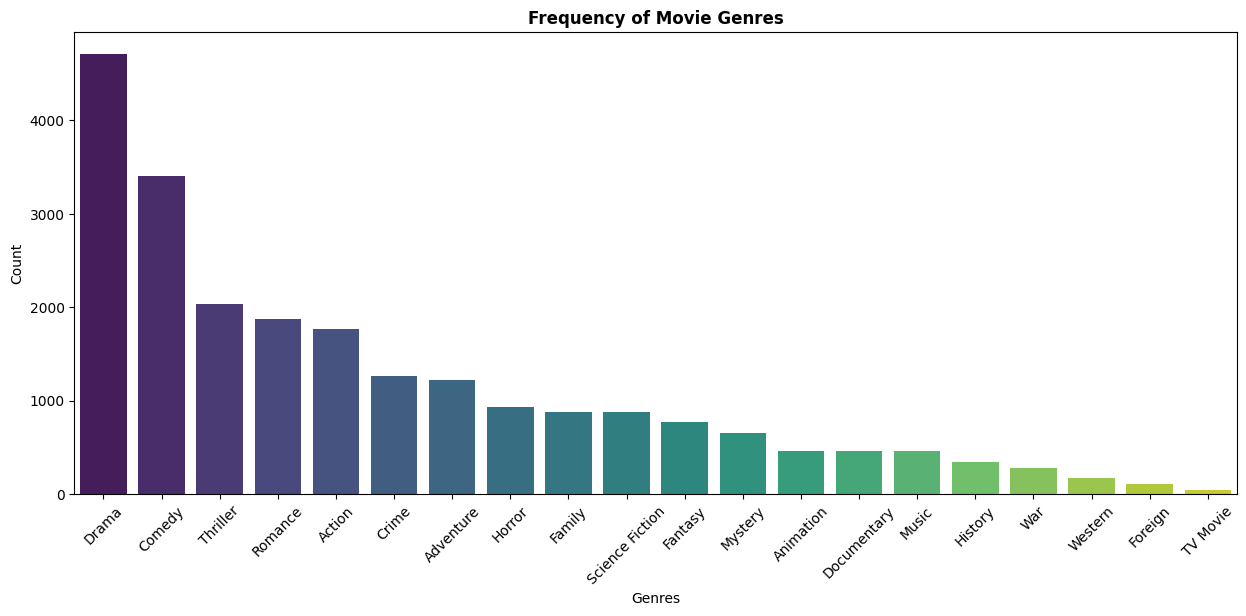

In [25]:
genres = data[data['genres'].str.len() > 0]
genres = genres.explode('genres')
genre_counts = genres['genres'].value_counts()

plt.figure(figsize=(15, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.title('Frequency of Movie Genres', fontweight = "bold")
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Drama holding the most number of Movie Genres amongst all genres following by Comedy, Thriller, Romance, and Action. Well it really represents most of people's taste of movies around me that like those genres, and the number of movies provided also support that fact!

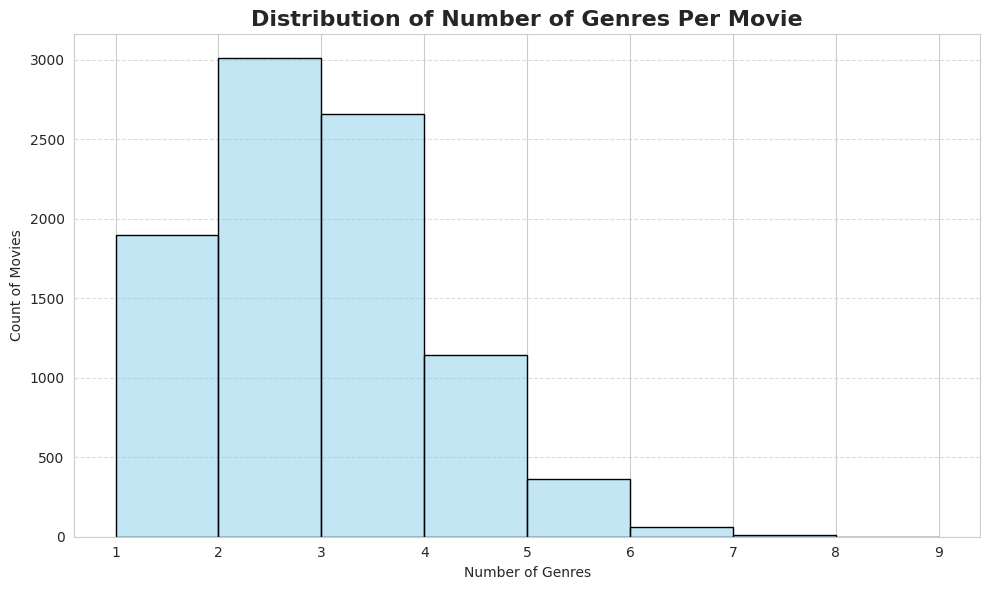

In [26]:
data['genre_count'] = data['genres'].apply(len)
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

bins = range(1, data['genre_count'].max() + 2)

sns.histplot(data['genre_count'], bins=bins, kde=False, color='skyblue', edgecolor='black', alpha = 0.5)
plt.title('Distribution of Number of Genres Per Movie', fontsize=16, fontweight='bold')
plt.xlabel('Number of Genres')
plt.ylabel('Count of Movies')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

A lot of genre in a movies sure is not a rare occasion, mixed genre should be something that Is good in a movie where it layers of things into that movie. Here we can see that most movies having 2 or more genres whill almost half of the movies only have one genre. Ensuring that the movies here are diverse in genre

## Language

Of course language become a crucial things to be considered in a movie, some people would refuse to watch a movie if they dont like how a language sound, not because they dont like the language but they just have their own preference and prefer to watch a movie with another language for them. Let's see the distribution of the original languages of the data

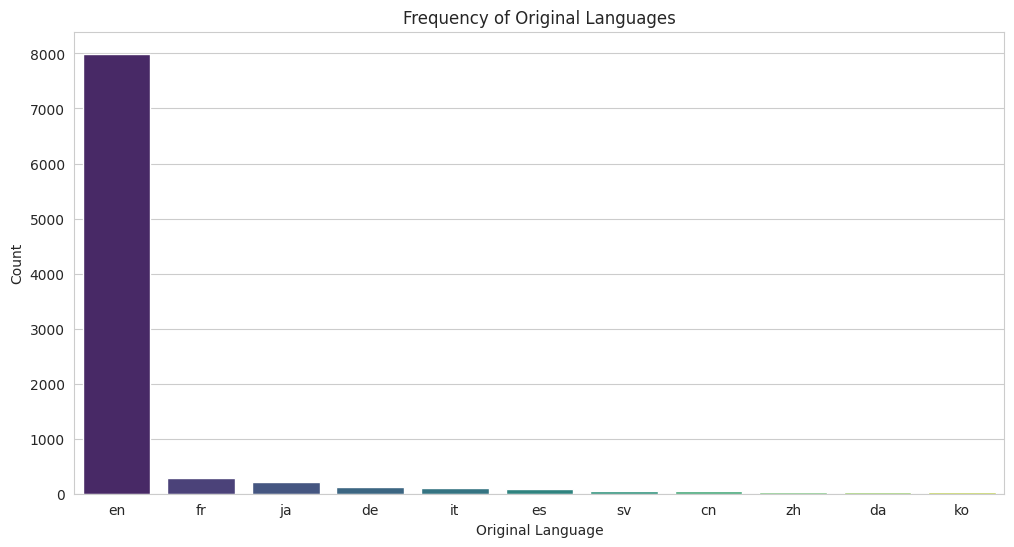

In [27]:
language_counts = data['original_language'].value_counts().nlargest(11)

plt.figure(figsize=(12, 6))
sns.barplot(x=language_counts.index, y=language_counts.values, palette='viridis')
plt.title('Frequency of Original Languages')
plt.xlabel('Original Language')
plt.ylabel('Count')
plt.show()

Here we can see that english significantly hold the top position becoming the dominator of the movies around the world, it also show the influence of hollywood movies in our world where it watched by many people around the world.<br> Lets see the distribution of another language beside of english to see another pattern

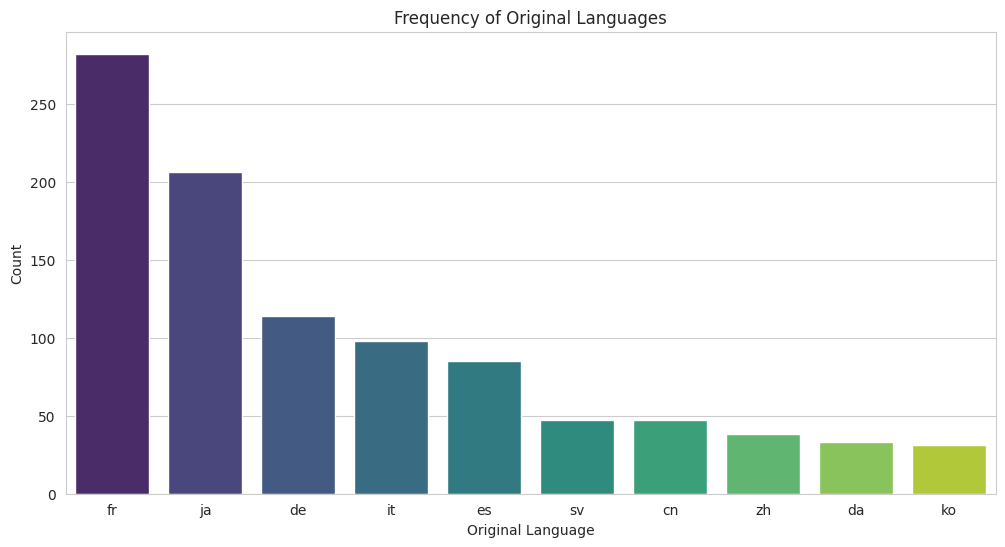

In [28]:
plt.figure(figsize=(12, 6))
sns.barplot(x=language_counts[1:11].index, y=language_counts[1:11].values, palette='viridis')
plt.title('Frequency of Original Languages')
plt.xlabel('Original Language')
plt.ylabel('Count')
plt.show()

Following after English, **French, Japanese, Denmark, and Italian** become the next most language for the movies

## Actor/Cast

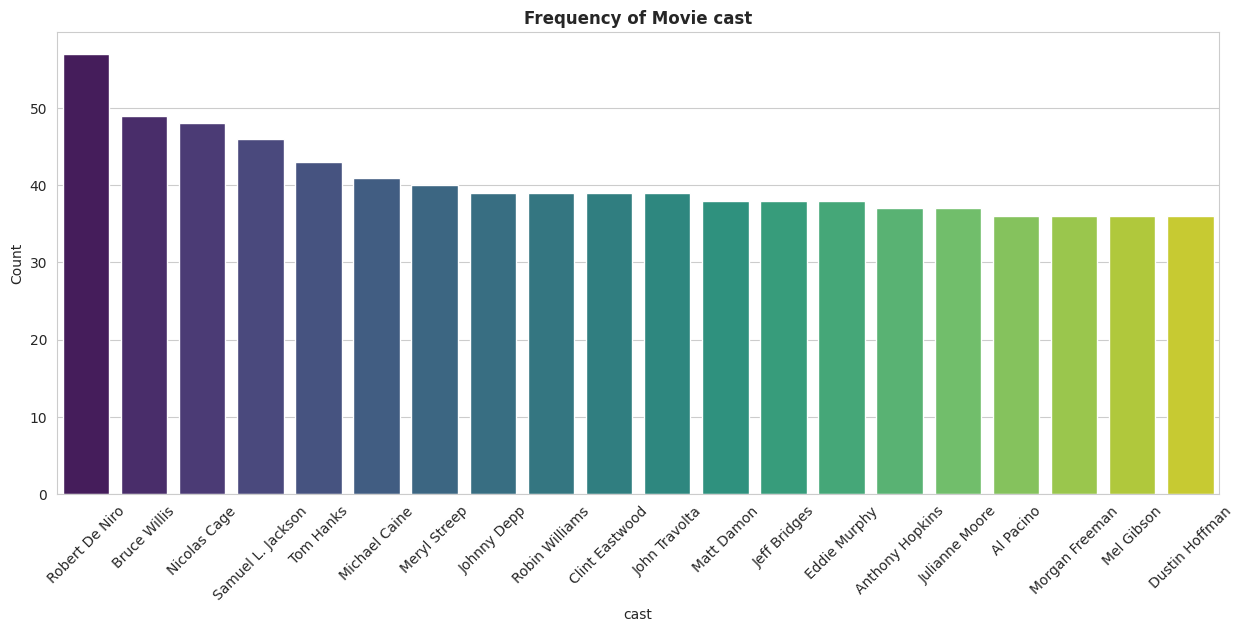

In [29]:
cast = data[data['cast'].str.len() > 0]
cast = cast.explode('cast')
cast_counts = cast['cast'].value_counts().nlargest(20)

plt.figure(figsize=(15, 6))
sns.barplot(x=cast_counts.index, y=cast_counts.values, palette='viridis')
plt.title('Frequency of Movie cast', fontweight = "bold")
plt.xlabel('cast')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Reccomender System

We are going to make the reccomender system with Content-based reccomendation using the features that we have chosen before. Now lets preprocess the data a bit more than before so we can do process the text even easier

## Copy the dataframe

Lets make a new dataframe variable so we have a backup for our data hehe<br> (it took sometime to run converting from dictionaries to string and I dont want to wait)

In [30]:
smd = data.copy()

## Make a soup feature

In [31]:
smd['genres'] = smd['genres'].apply(lambda x: ' '.join(x))
smd['cast'] = smd['cast'].apply(lambda x: ' '.join(x))
smd['keywords'] = smd['keywords'].apply(lambda x: ' '.join(x))
smd['director_names'] = smd['director_names'].apply(lambda x: ' '.join(x))

In [32]:
smd.head()

,id,title,genres,overview,original_language,cast,keywords,director_names,genre_count
0,862,Toy Story,Animation Comedy Family,"Led by Woody, Andy's toys live happily in his ...",en,Tom Hanks Tim Allen Don Rickles,jealousy toy boy friendship friends rivalry bo...,John Lasseter,3
1,8844,Jumanji,Adventure Fantasy Family,When siblings Judy and Peter discover an encha...,en,Robin Williams Jonathan Hyde Kirsten Dunst,board game disappearance based on children's b...,Joe Johnston,3
2,15602,Grumpier Old Men,Romance Comedy,A family wedding reignites the ancient feud be...,en,Walter Matthau Jack Lemmon Ann-Margret,fishing best friend duringcreditsstinger old men,Howard Deutch,2
3,31357,Waiting to Exhale,Comedy Drama Romance,"Cheated on, mistreated and stepped on, the wom...",en,Whitney Houston Angela Bassett Loretta Devine,based on novel interracial relationship single...,Forest Whitaker,3
4,11862,Father of the Bride Part II,Comedy,Just when George Banks has recovered from his ...,en,Steve Martin Diane Keaton Martin Short,baby midlife crisis confidence aging daughter ...,Charles Shyer,1


Since the **overview** column contains significantly more words than other features, using TF-IDF directly could skew the recommendations heavily toward it. This may make other important features, like genres, keywords, cast, and director_names, seem less significant in the similarity computation. To address this, I **apply weights** to these features, ensuring their importance is recognized and resulting in more balanced and diverse recommendations.

In [33]:
def create_soup(row):
    genres = ' '.join([row['genres']] * 3) if row['genres'] else ''
    keywords = ' '.join([row['keywords']] * 3) if row['keywords'] else ''
    cast = ' '.join([row['cast']] * 2) if row['cast'] else ''
    director = ' '.join([row['director_names']] * 2) if row['director_names'] else ''
    overview = row['overview'] if row['overview'] else ''
    return f"{genres} {keywords} {cast} {director} {overview}"
smd['soup'] = smd.apply(create_soup, axis=1)

In [34]:
print(smd['soup'].iloc[0])

Animation Comedy Family Animation Comedy Family Animation Comedy Family jealousy toy boy friendship friends rivalry boy next door new toy toy comes to life jealousy toy boy friendship friends rivalry boy next door new toy toy comes to life jealousy toy boy friendship friends rivalry boy next door new toy toy comes to life Tom Hanks Tim Allen Don Rickles Tom Hanks Tim Allen Don Rickles John Lasseter John Lasseter Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.


This way we create a **soup** features that is a form of the concats of the string features that later we will use as our reccomendation feature.

## Apply TF-IDF

In order to transform our textual data into a numerical format that can be understood by machine learning algorithms, we use TF-IDF Vectorization. <br>

The resulting tfidf_matrix is a numerical representation of the text data in the soup column, where each row corresponds to a movie and each column corresponds to a unique word that appeared across all movies. Higher values indicate that a word is more important in the given document (movie), while lower values indicate less significance. <br>

This transformation allows us to measure the similarity between movies based on the words that appear in their soup, and is essential for calculating how similar different movies are to one another using techniques like cosine similarity.

In [35]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(smd['soup'])

In [36]:
print(tfidf_matrix.shape)

(9174, 40279)


## Count the cosine similarity

Once we have transformed our textual data into numerical vectors using TF-IDF, the next step is to calculate the cosine similarity between the movies. Cosine similarity is a metric used to determine how similar two vectors (in our case, movie descriptions) are, based on their angle in a multi-dimensional space. This helps in identifying which movies are most similar to a given movie.

In [37]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

## Build the reccomendation system

In [38]:
indices = pd.Series(smd.index, index=smd['title'])

In [39]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # index of the movie that matches the title
    idx = indices[title]

    # similarity score
    sim_scores = list(enumerate(cosine_sim[idx]))

    # sort based on sim score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # index for 10 similar movies
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]

    return smd['title'].iloc[movie_indices]

def get_recommendations_with_details(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[0:11]
    movie_indices = [i[0] for i in sim_scores]

    return smd[['title', 'genres', 'overview', 'cast', 'keywords', 'director_names']].iloc[movie_indices]

# Evaluating the content-based reccomender system

# Qualitatively evaluating the model based on the reccomendation it given

In [40]:
recommendations = get_recommendations('Jumanji')
recommendations

,title
2276,Clue
14255,Where the Wild Things Are
2030,The NeverEnding Story
2151,Them!
8488,Rodan
10534,Zathura: A Space Adventure
10674,Grandma's Boy
24173,Ouija
30018,Zenon: Girl of the 21st Century
26244,Warcraft


In [41]:
recommendations = get_recommendations_with_details("Toy Story")
recommendations

,title,genres,overview,cast,keywords,director_names
0,Toy Story,Animation Comedy Family,"Led by Woody, Andy's toys live happily in his ...",Tom Hanks Tim Allen Don Rickles,jealousy toy boy friendship friends rivalry bo...,John Lasseter
15307,Toy Story 3,Animation Family Comedy,"Woody, Buzz, and the rest of Andy's toys haven...",Tom Hanks Tim Allen Ned Beatty,hostage college toy barbie animation escape da...,Lee Unkrich
1789,Small Soldiers,Comedy Adventure Fantasy Science Fiction Action,When missile technology is used to enhance toy...,Gregory Smith Kirsten Dunst Denis Leary,defense industry toy shop technical toy soldie...,Joe Dante
2975,Toy Story 2,Animation Comedy Family,"Andy heads off to Cowboy Camp, leaving his toy...",Tom Hanks Tim Allen Joan Cusack,museum prosecution identity crisis airplane fl...,John Lasseter
2119,Toys,Fantasy Comedy Science Fiction,Leslie Zevo is a fun-loving inventor who must ...,Robin Williams Michael Gambon Joan Cusack,brother brother relationship loss of brother l...,Barry Levinson
7533,Dolls,Fantasy Horror,A group of people stop by a mansion during a s...,Ian Patrick Williams Carolyn Purdy-Gordon Carr...,toy gore storm doll toy maker,Stuart Gordon
1860,Child's Play,Horror Thriller,A single mother gives her son a beloved doll f...,Catherine Hicks Chris Sarandon Alex Vincent,gun birthday voodoo toy stalker murder blood s...,Tom Holland
3855,The Transformers: The Movie,Animation,The Autobots must stop a colossal planet-consu...,Judd Nelson Peter Cullen Frank Welker,toy transformation based on toy transformers r...,Nelson Shin
12166,Mr. Magorium's Wonder Emporium,Comedy,Molly Mahoney is the awkward and insecure mana...,Dustin Hoffman Natalie Portman Jason Bateman,magic fantasy darkness toy sell faith puppet w...,Zach Helm
1608,Home Alone 3,Comedy Family,9-year-old Alex Pruitt is home alone with the ...,Alex D. Linz Olek Krupa Rya Kihlstedt,parent child relationship burglar child hero a...,Raja Gosnell


# Build a hybrid reccomendation

Of course, it would be even better to incorporate content-based learning with user preferences to tailor more personalized recommendations. By leveraging the ratings data in the SMD dataset, we can enhance our collaborative recommender system, using these ratings as the foundation for user-based preference predictions. This approach will complement content-based recommendations, particularly addressing the cold-start problem, where limited user data might otherwise hinder the accuracy of suggestions.

First lets just import the dataset of the ratings

In [42]:
reader = Reader()

In [43]:
ratings = pd.read_csv('/content/drive/MyDrive/MLDataset/ratings_small.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [44]:
rating_matrix = ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)

## Build the collaborative reccomendation system first

In [45]:
reccomendationData = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [46]:
svd = SVD()
results = cross_validate(svd, reccomendationData, measures=['RMSE'], cv=5, verbose=True)
print("Cross-validated RMSE:", results['test_rmse'])

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8955  0.8921  0.9042  0.8869  0.9002  0.8958  0.0060  
Fit time          1.38    1.56    1.87    2.78    2.48    2.01    0.53    
Test time         0.27    0.13    0.26    0.64    0.10    0.28    0.19    
Cross-validated RMSE: [0.89550048 0.89213436 0.90423159 0.88694456 0.90019237]


An RMSE of 0.8965 indicates that our recommender system delivers reasonably accurate predictions, with an average error of less than 1 rating point. This suggests that the system is capable of providing decent accuracy when recommending movies to our users, ensuring a satisfactory level of relevance in the recommendations.

### Train the SVD model with the data we have

In [47]:
trainset = reccomendationData.build_full_trainset()
svd.fit(trainset)

### Building the hybrid reccomendation

In [48]:
id_map = pd.read_csv('/content/drive/My Drive/MLDataset/links_small.csv')[['movieId', 'tmdbId']]
id_map.dropna(inplace=True)
id_map['tmdbId'] = id_map['tmdbId'].astype('int')
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(smd[['title', 'id']], on='id').set_index('title')
indices_map = id_map.set_index('id')

In [49]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    movie_id = id_map.loc[title]['movieId']

    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]

    movies = smd.iloc[movie_indices][['title','genres','id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [50]:
recom = hybrid(1, 'Toy Story')
display(recom)

,title,genres,id,est
15307,Toy Story 3,Animation Family Comedy,10193,3.166123
7533,Dolls,Fantasy Horror,24341,2.729852
2975,Toy Story 2,Animation Comedy Family,863,2.724081
21734,Toy Story of Terror!,Animation Comedy Family,213121,2.706706
3855,The Transformers: The Movie,Animation,1857,2.622583
12166,Mr. Magorium's Wonder Emporium,Comedy,2284,2.573961
1860,Child's Play,Horror Thriller,10585,2.520029
1789,Small Soldiers,Comedy Adventure Fantasy Science Fiction Action,11551,2.174914
2119,Toys,Fantasy Comedy Science Fiction,11597,2.169293
1608,Home Alone 3,Comedy Family,9714,1.964487


In [51]:
recom = hybrid(144, 'Toy Story')
display(recom)

,title,genres,id,est
15307,Toy Story 3,Animation Family Comedy,10193,4.150740
2975,Toy Story 2,Animation Comedy Family,863,3.773193
7533,Dolls,Fantasy Horror,24341,3.697689
3855,The Transformers: The Movie,Animation,1857,3.528667
21734,Toy Story of Terror!,Animation Comedy Family,213121,3.516428
12166,Mr. Magorium's Wonder Emporium,Comedy,2284,3.495106
1860,Child's Play,Horror Thriller,10585,3.372386
2119,Toys,Fantasy Comedy Science Fiction,11597,3.022368
1789,Small Soldiers,Comedy Adventure Fantasy Science Fiction Action,11551,2.972250
1608,Home Alone 3,Comedy Family,9714,2.849458


We can see here by choosing Toy Story, we get different reccomendation for each user 799 and 144. But also we can see that the reccomendation is still relevant to the content because the presence of some Toy Story franchise also appear there. A lot of movies with same genres also present in the reccomendation as well